# =============================
#   Graph Neural Network Tutorial
# =============================

In this tutorial, you'll learn:

1) How to handle basic graph operations with NetworkX (a Python library for network analysis).  
2) How to handle graph data and build Graph Neural Networks (GNNs) with PyTorch Geometric (PyG).  
3) How to apply GNNs to:  
   - A small, well-known graph (Zachary's Karate Club) for node-level classification.  
   - Larger real-world datasets for node-level and graph-level property prediction (via the OGB benchmarks).

This notebook is split into two main sections:

**A) NetworkX Basics**  
**B) Introduction to PyTorch Geometric and Graph Neural Networks**

We will install and demonstrate important functionalities, then finish with end-to-end GNN examples.


In [2]:
# ================================================================
#               A) NETWORKX TUTORIAL
# ================================================================

# We first install and import NetworkX. 
# For demonstration, we also install (and pin) a specific scipy version if needed.
!pip install --upgrade networkx
!pip install scipy==1.13.0
!pip install matplotlib

import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------------------------
# Graph Creation
# ------------------------------------------------
print("NETWORKX TUTORIAL\n")

# Create an undirected graph G
G = nx.Graph()
print("Is G directed?", G.is_directed())

# Create a directed graph H
H = nx.DiGraph()
print("Is H directed?", H.is_directed())

# Add a graph-level attribute
G.graph["Name"] = "ExampleUndirectedGraph"
print("Graph-level attributes:", G.graph)


NETWORKX TUTORIAL

Is G directed? False
Is H directed? True
Graph-level attributes: {'Name': 'ExampleUndirectedGraph'}


In [3]:
# ------------------------------------------------
# Node Handling
# ------------------------------------------------
# Add one node with attributes
G.add_node(0, feature=5, label=1)
node_0_attr = G.nodes[0]
print("\nNode 0 attributes:", node_0_attr)

# Add multiple nodes with attributes
G.add_nodes_from([
    (1, {"feature": 1, "label": 1}),
    (2, {"feature": 2, "label": 2})
])

print("\nAll nodes (with attributes):")
for node in G.nodes(data=True):
    print(node)

num_nodes = G.number_of_nodes()
print("Number of nodes in G:", num_nodes)



Node 0 attributes: {'feature': 5, 'label': 1}

All nodes (with attributes):
(0, {'feature': 5, 'label': 1})
(1, {'feature': 1, 'label': 1})
(2, {'feature': 2, 'label': 2})
Number of nodes in G: 3


In [4]:
# ------------------------------------------------
# Edge Handling
# ------------------------------------------------
# Add one edge with an edge-weight attribute
G.add_edge(0, 1, weight=0.5)
edge_0_1_attr = G.edges[(0, 1)]
print("\nEdge (0,1) attributes:", edge_0_1_attr)

# Add multiple edges
G.add_edges_from([
    (1, 2, {"weight": 0.3}),
    (2, 0, {"weight": 0.1})
])

print("\nAll edges in G:")
for edge in G.edges():
    print(edge)

num_edges = G.number_of_edges()
print("Number of edges in G:", num_edges)



Edge (0,1) attributes: {'weight': 0.5}

All edges in G:
(0, 1)
(0, 2)
(1, 2)
Number of edges in G: 3



Visualizing G...


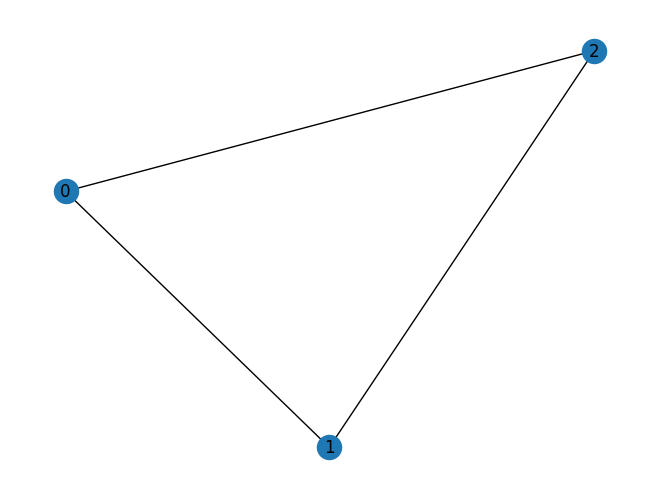

In [5]:
# ------------------------------------------------
# Visualization
# ------------------------------------------------
print("\nVisualizing G...")
nx.draw(G, with_labels=True)
plt.show()


In [6]:
# ------------------------------------------------
# Node Degree & Neighbors
# ------------------------------------------------
node_id = 1
print(f"\nNode {node_id} has degree {G.degree[node_id]}")
print(f"Neighbors of node {node_id}:")
for neighbor in G.neighbors(node_id):
    print(" ->", neighbor)



Node 1 has degree 2
Neighbors of node 1:
 -> 0
 -> 2



Another graph (directed path) with 4 nodes, G2:


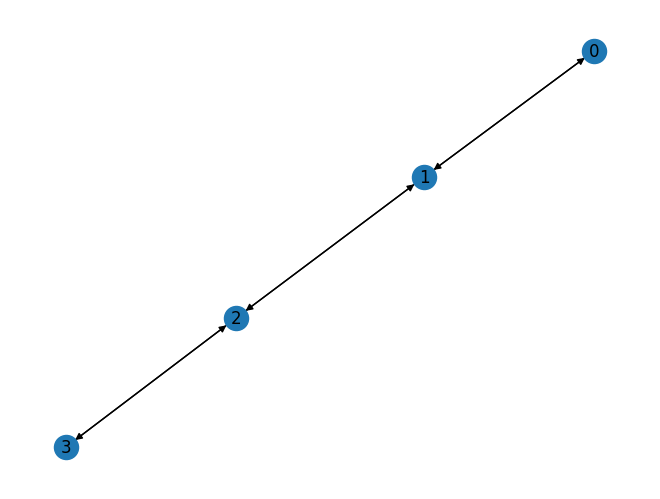

PageRank of G2: {0: 0.17857162031103999, 1: 0.32142837968896, 2: 0.32142837968896, 3: 0.17857162031103999}

--- End of NetworkX basics ---



In [7]:
# ------------------------------------------------
# Other Functionalities: PageRank Example
# ------------------------------------------------
num_nodes_example = 4
G2 = nx.DiGraph(nx.path_graph(num_nodes_example))
print("\nAnother graph (directed path) with 4 nodes, G2:")
nx.draw(G2, with_labels=True)
plt.show()

pr = nx.pagerank(G2, alpha=0.8)
print("PageRank of G2:", pr)

print("\n--- End of NetworkX basics ---\n")


# ================================================================
#     B) Pytorch Geometric & Graph Neural Networks
# ================================================================

PyTorch Geometric (PyG) is an extension of PyTorch for deep learning on irregular structures like graphs.

We'll go step by step:

1) Installation & Setup  
2) An example on the small 'Zachary's Karate Club' dataset  
3) Introduction to GNNs (via a simple `GCNConv`)  
4) Implementation of a 3-layer GCN for node classification  
5) Demonstration on real-world data from Open Graph Benchmark (OGB)  
   - Node-level classification (`ogbn-arxiv`)  
   - Graph-level classification (`ogbg-molhiv`)  

---


In [25]:
print("PYTORCH GEOMETRIC TUTORIAL\n")
!pip install torch
import torch
print(f"PyTorch version: {torch.__version__}")

# -------------
# Install PyG
# -------------
# Installing PyTorch Geometric can be a bit tricky. We'll install 
# based on the current PyTorch version.

# The commands below are typical for Colab w/ a CUDA environment.
# They may change if your environment differs (CPU-only or different CUDA version).
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html
  
# We also install OGB for loading standard benchmarks.
!pip install -q ogb

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

%matplotlib inline
import networkx as nx


PYTORCH GEOMETRIC TUTORIAL

PyTorch version: 2.5.1
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.3/619.3 kB 13.2 MB/s eta 0:00:00


In [28]:
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    """
    A small helper function to visualize either:
      - A NX graph + color-coded nodes
      - A 2D scatter of node embeddings (PyTorch tensor) with color-coded classes

    If 'h' is a tensor, we scatter-plot.
    If 'h' is a networkx graph, we draw it with nx.draw().
    """
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        # Node embeddings
        h_ = h.detach().cpu().numpy()
        plt.scatter(h_[:, 0], h_[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy is not None:
            tr_acc = accuracy.get("train", 0)*100
            val_acc = accuracy.get("val", 0)*100
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f}\n'
                       f'Train Accuracy: {tr_acc:.2f}% | Val Accuracy: {val_acc:.2f}%'),
                       fontsize=14)
    else:
        # h is a networkx graph
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


## Zachary's Karate Club (Node Classification)

# Data:

- A single small social network of 34 members of a karate club.
- Nodes represent club members.
- Edges indicate that two members frequently interact outside the club.

# Goal:

- Node classification—we want to classify each member into one of the “communities” that form in this network.
- The dataset provides training labels for only a few nodes (one node per community), and we want to infer the community membership for the remaining nodes using a GNN.

# Key Points:

- Demonstrates semi-supervised learning on a single small graph.
- Each node is assigned a feature vector (often a one-hot or identity) plus a community label.
- We build a simple 3-layer GCN that aggregates neighbor information and predicts which community each node belongs to.


--- Zachary's Karate Club Example ---

Dataset: KarateClub()
Number of graphs in dataset: 1
Number of features: 34
Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.588235294117647
Train mask covers how many nodes: 4
Train mask fraction: 0.11764705882352941
Contains isolated nodes? False
Contains self-loops? False
Is undirected? True

Edge Index of the Karate Club graph:
 tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
    

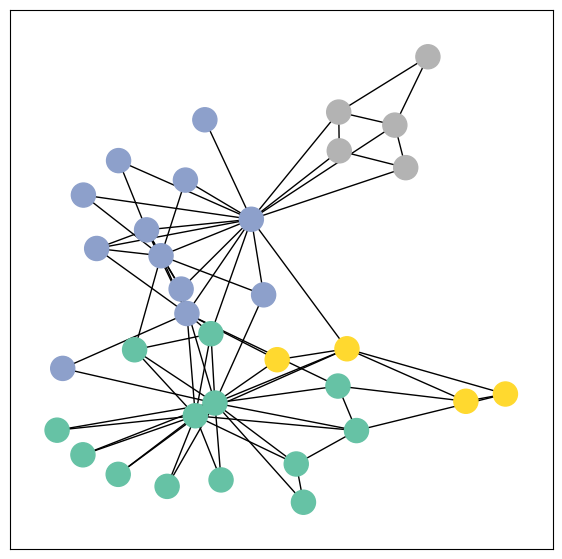

In [29]:
# -----------------------------------------------------------
#   Example: Zachary's Karate Club (Node Classification)
# -----------------------------------------------------------

print("\n--- Zachary's Karate Club Example ---\n")

from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f"Dataset: {dataset}")
print(f"Number of graphs in dataset: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# This dataset only has one graph (the famous Karate Club).
# Let's examine it:
data = dataset[0]
print(data)
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Average node degree:", data.num_edges / data.num_nodes)
print("Train mask covers how many nodes:", data.train_mask.sum().item())
print("Train mask fraction:", int(data.train_mask.sum()) / data.num_nodes)
print("Contains isolated nodes?", data.has_isolated_nodes())
print("Contains self-loops?", data.has_self_loops())
print("Is undirected?", data.is_undirected())

edge_index = data.edge_index
print("\nEdge Index of the Karate Club graph:\n", edge_index.t())

# Visualize the graph structure via networkx:
G_karate = to_networkx(data, to_undirected=True)
visualize(G_karate, color=data.y)


In [30]:
# --------------------------------------
# Create a simple GCN model
# --------------------------------------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(1234)

        # We stack three GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)
        self.conv3 = GCNConv(hidden_channels // 2, hidden_channels // 4)

        # Final linear classifier
        self.classifier = torch.nn.Linear(hidden_channels // 4, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = torch.tanh(h)

        h = self.conv2(h, edge_index)
        h = torch.tanh(h)

        h = self.conv3(h, edge_index)
        h = torch.tanh(h)  # final GNN node embedding

        # Classifier
        out = self.classifier(h)
        return out, h

model = GCN(dataset.num_features, 16, dataset.num_classes)
print(model)


GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 8)
  (conv3): GCNConv(8, 4)
  (classifier): Linear(in_features=4, out_features=4, bias=True)
)


Embedding shape: torch.Size([34, 4])


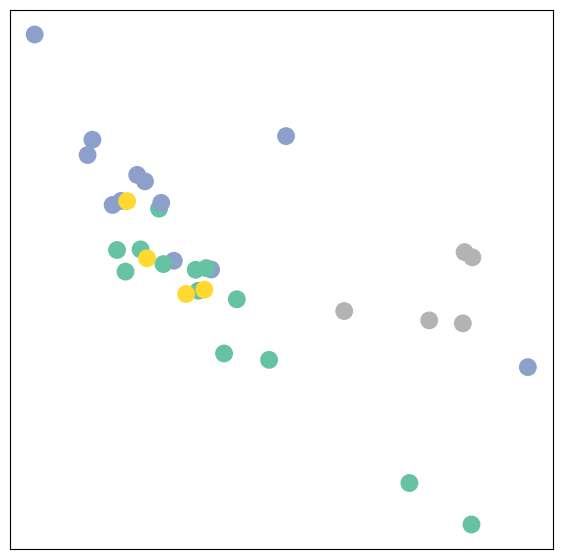

In [19]:
# Checking random initial embeddings
_, h = model(data.x, data.edge_index)
print("Embedding shape:", h.shape)
visualize(h, color=data.y)

# We see that even random initialization somewhat groups the communities.


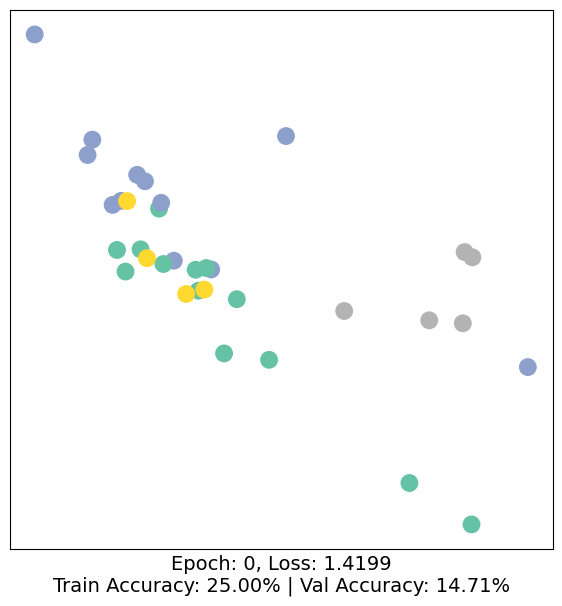

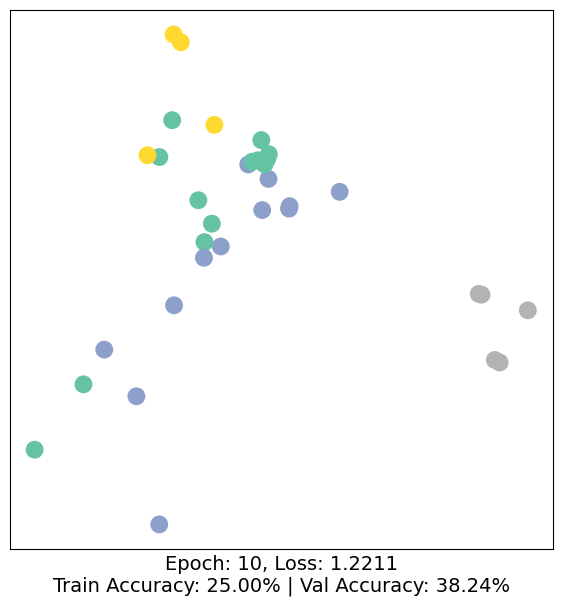

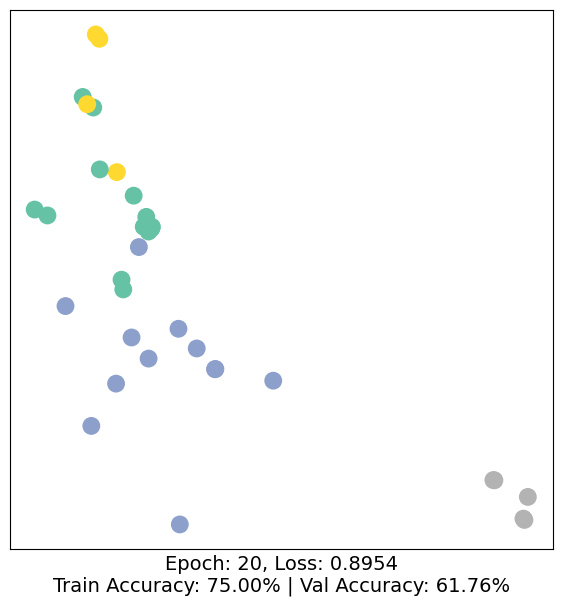

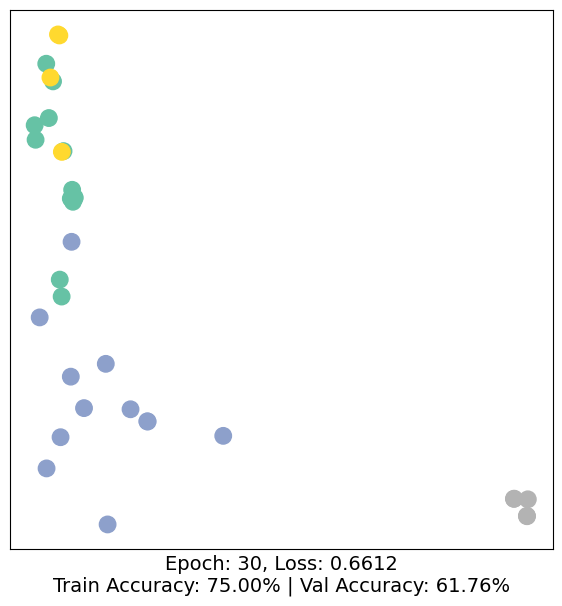

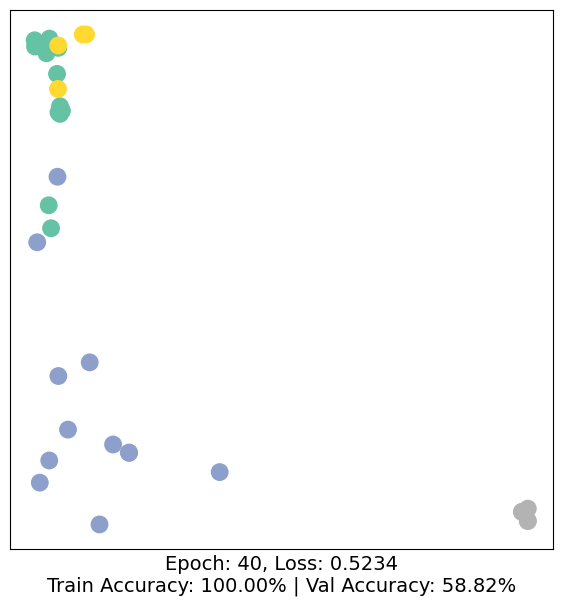

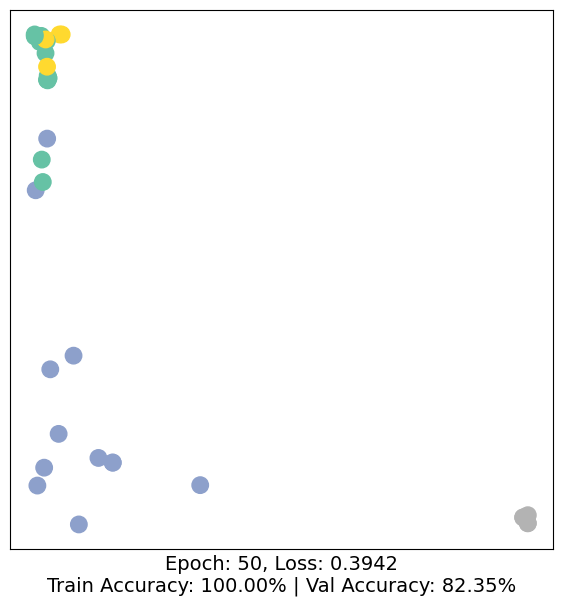

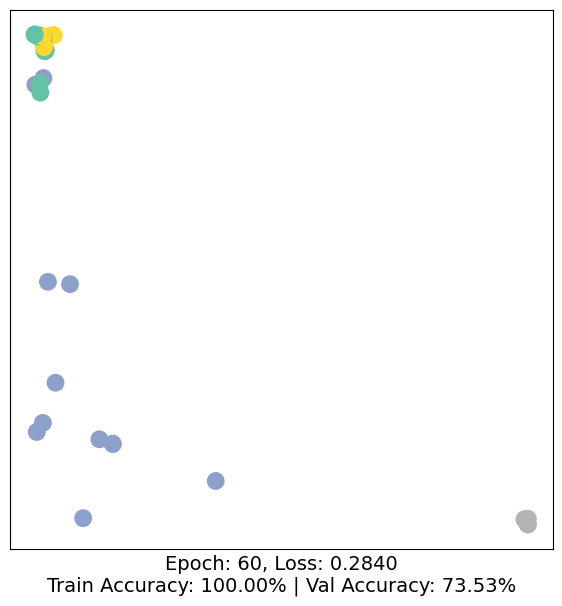

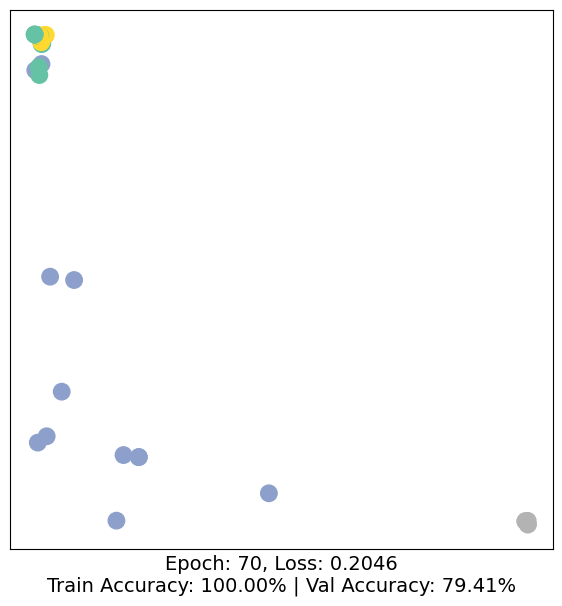

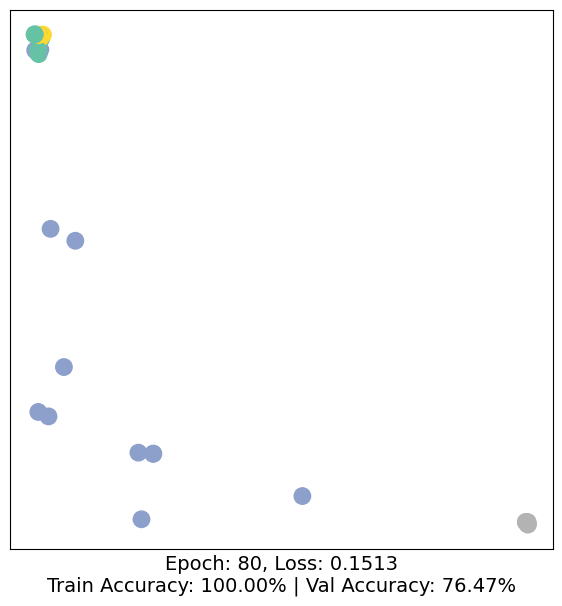

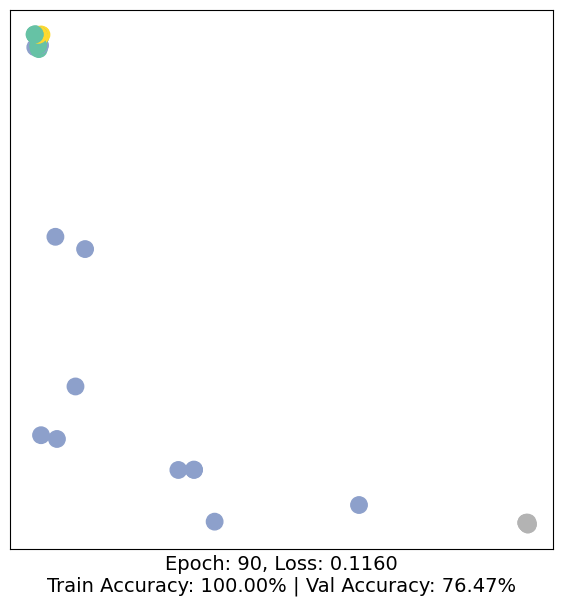

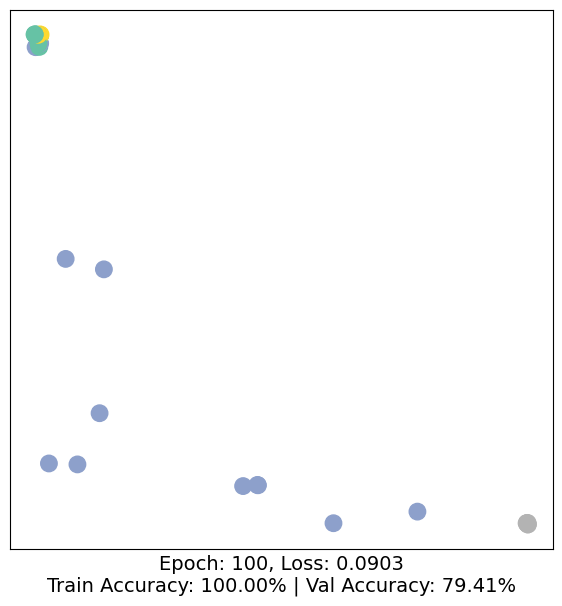

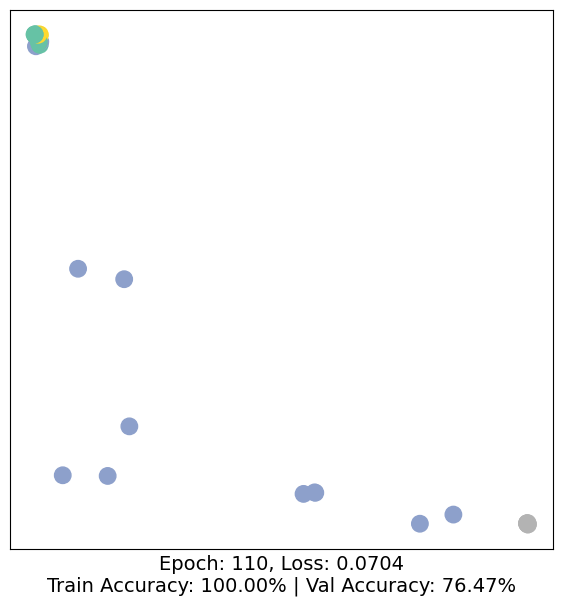

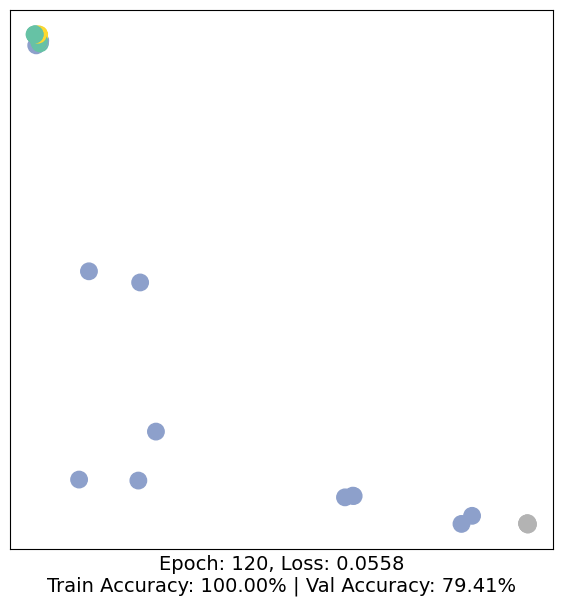

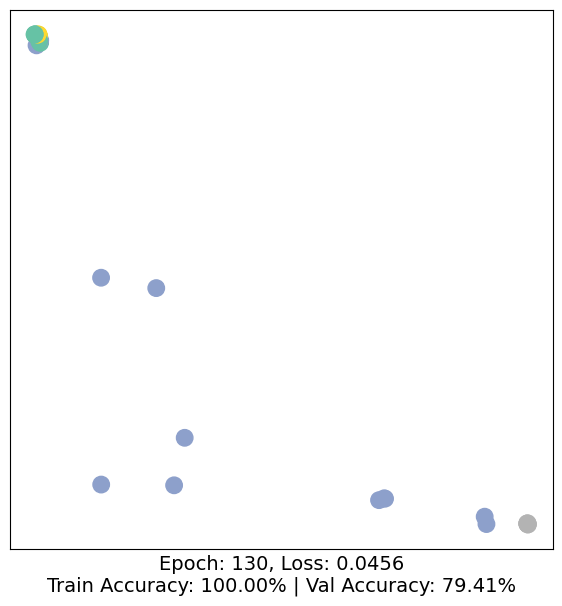

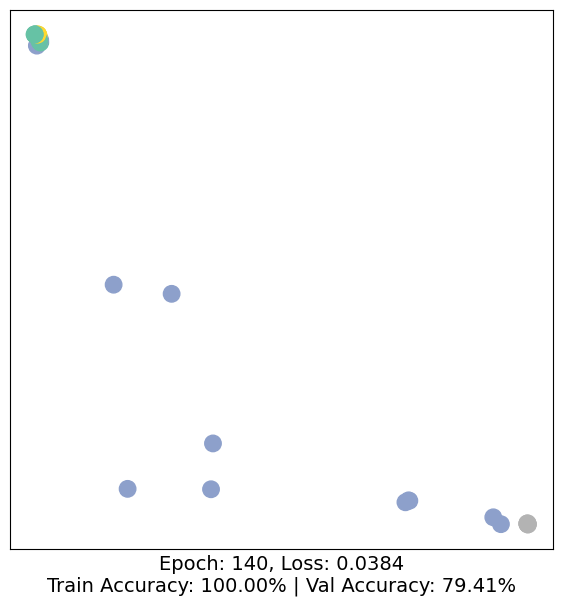

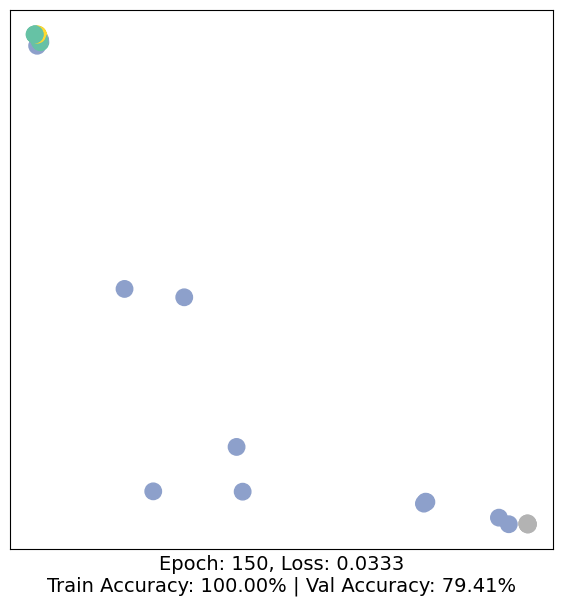

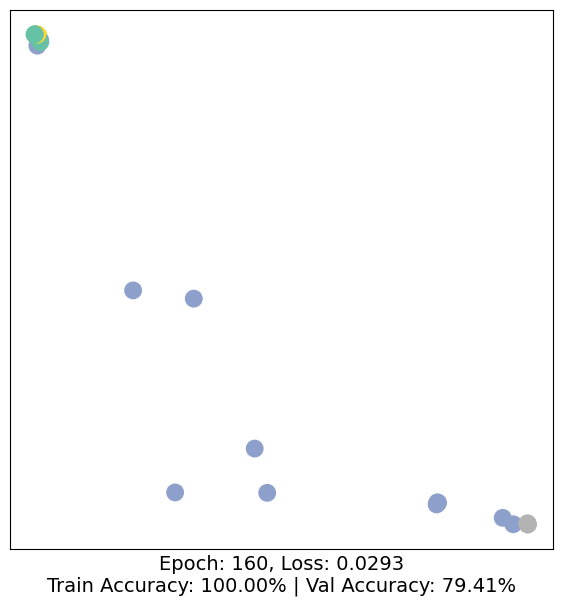

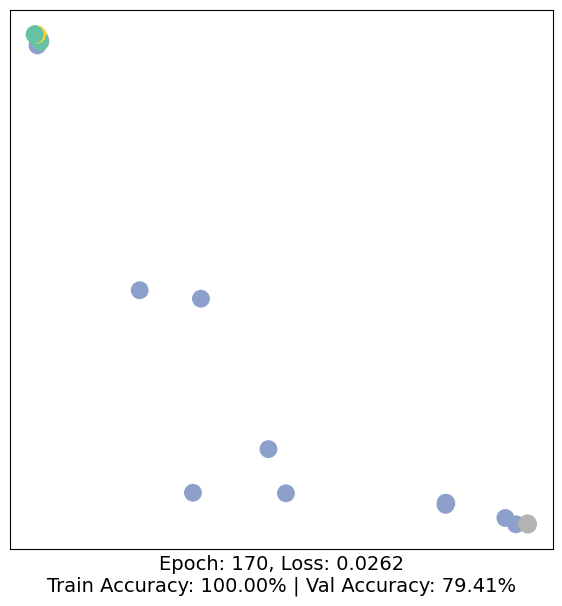

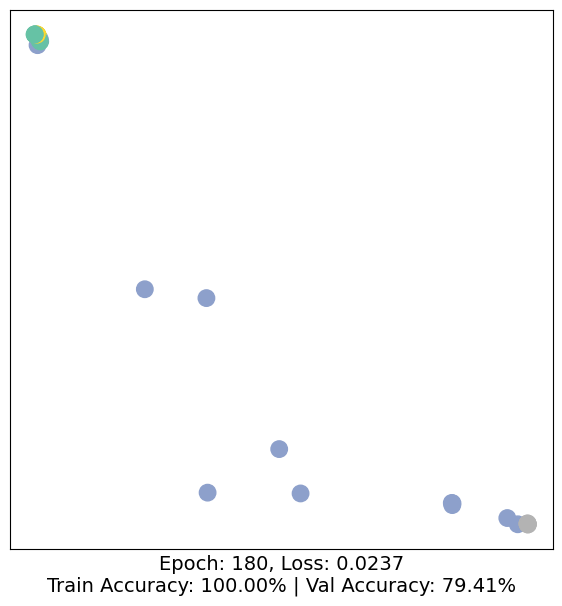

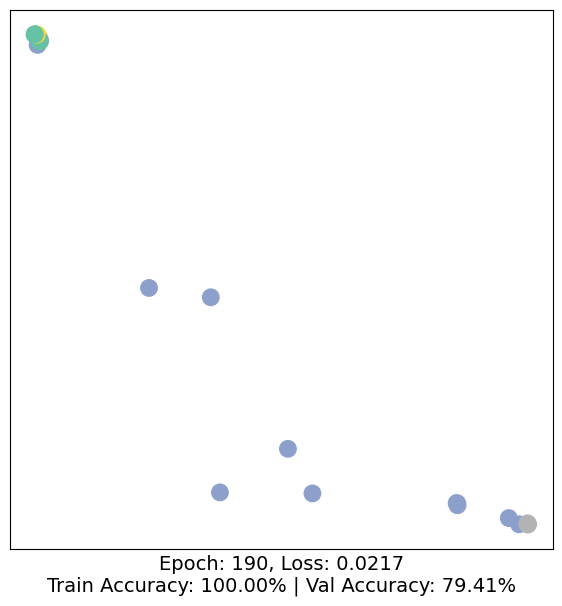

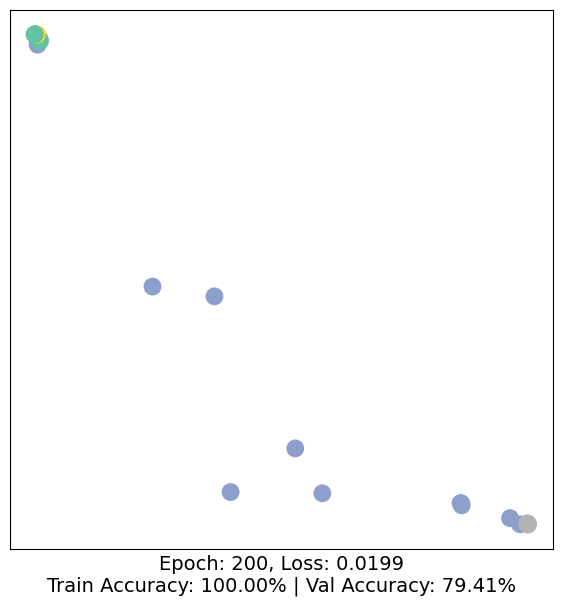

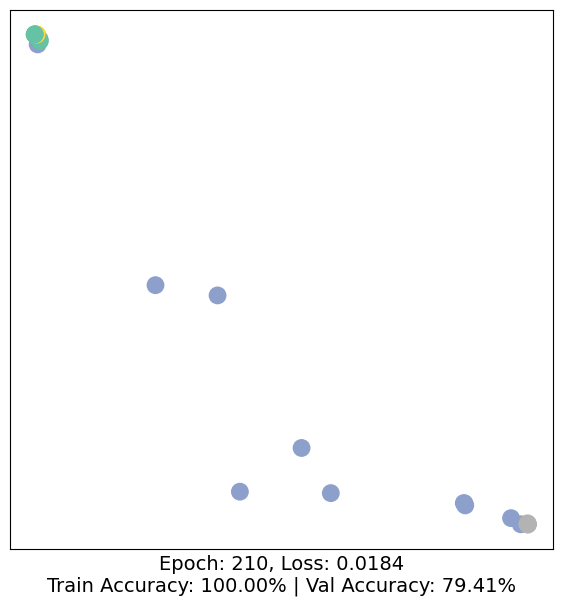

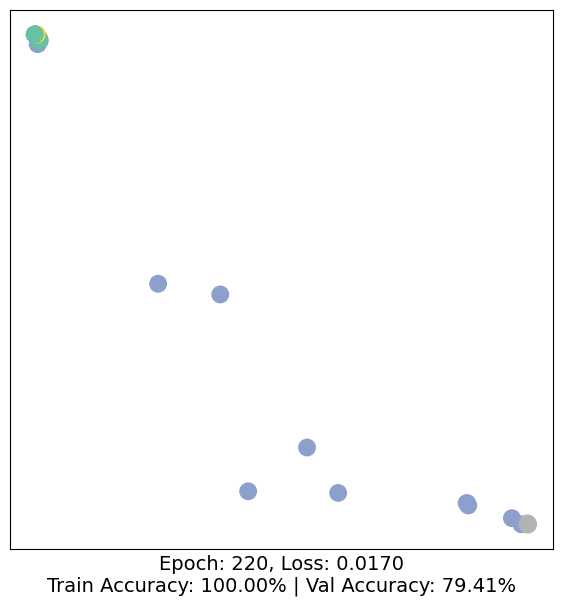

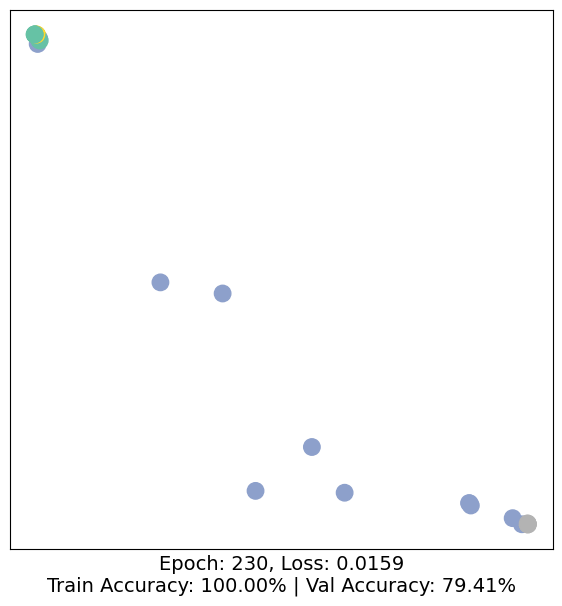

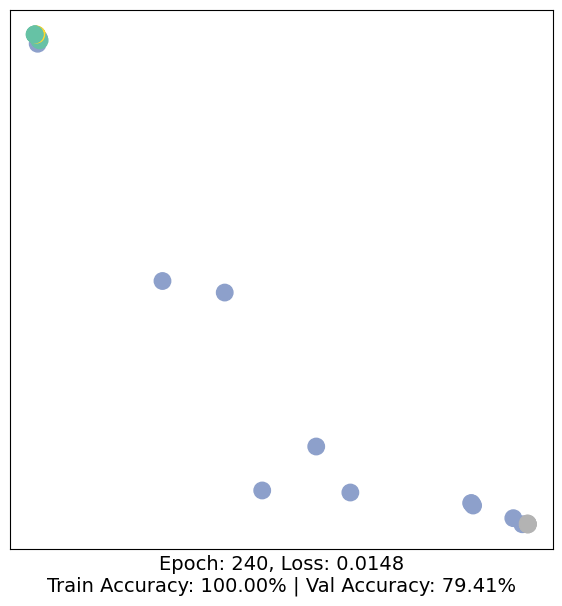

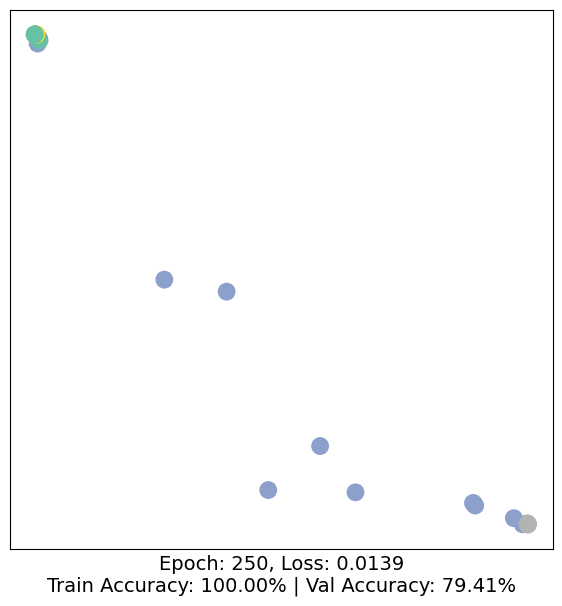

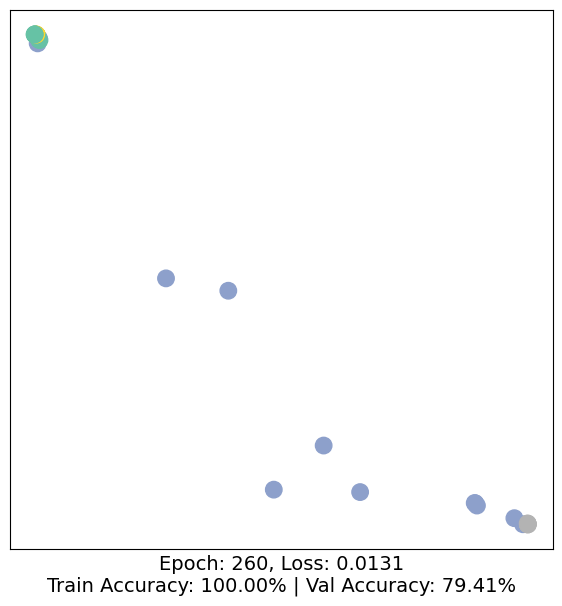

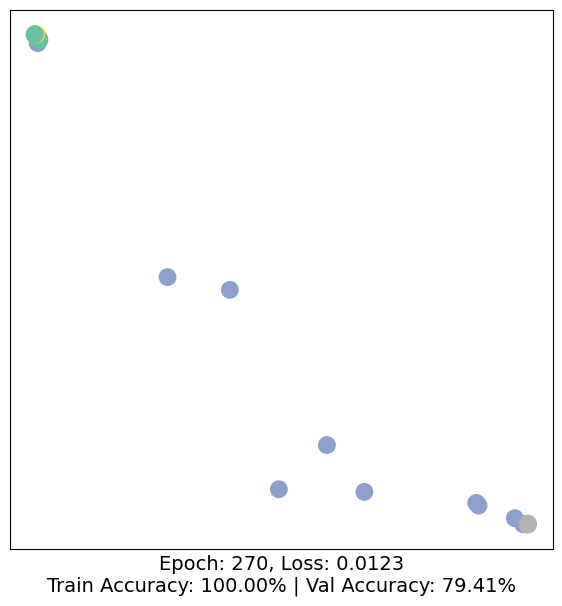

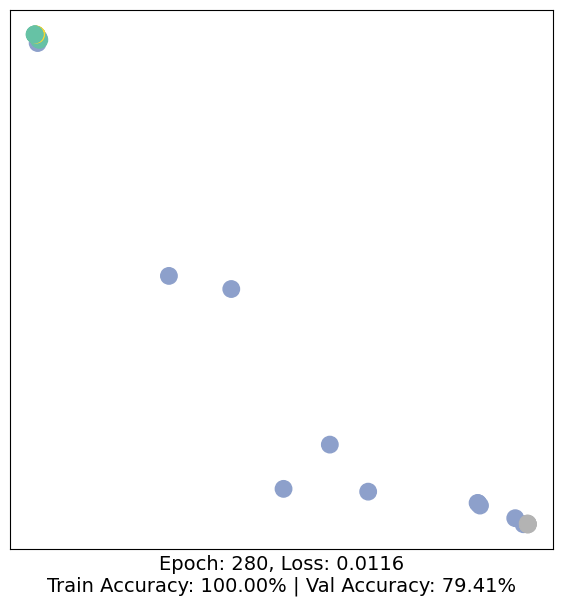

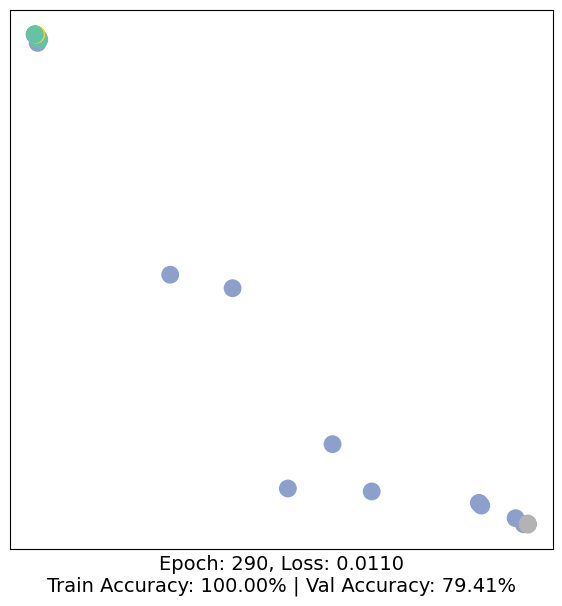

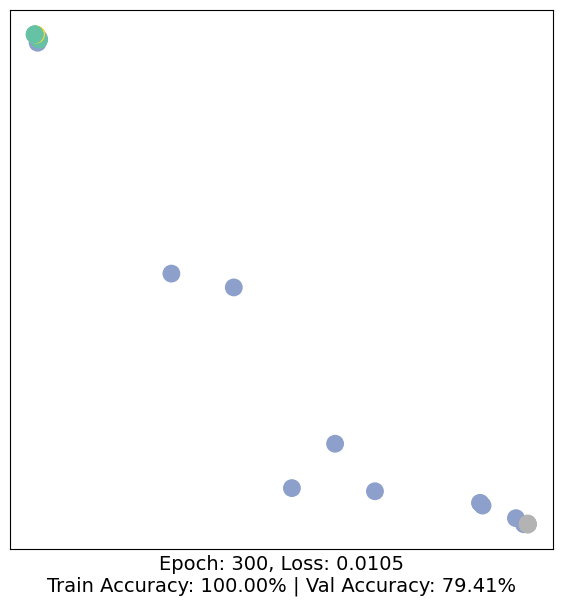

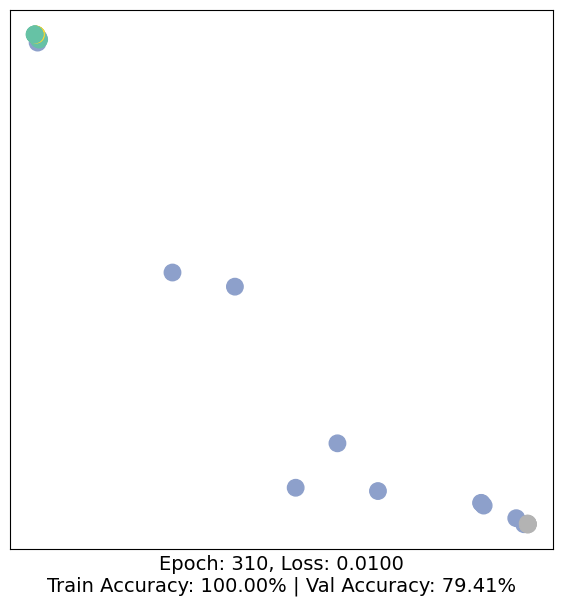

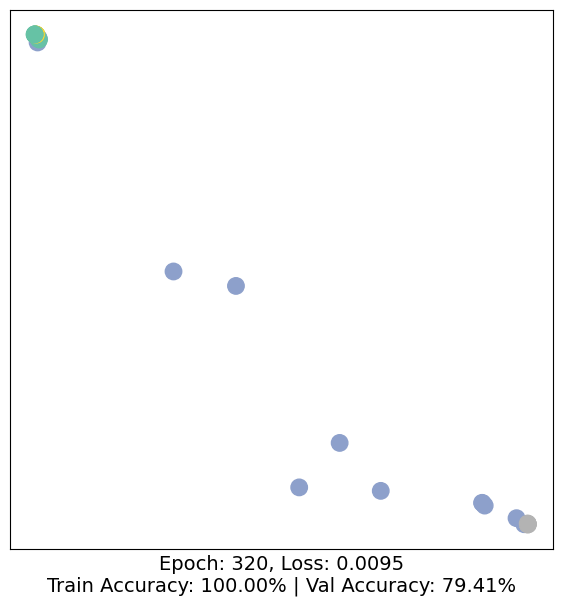

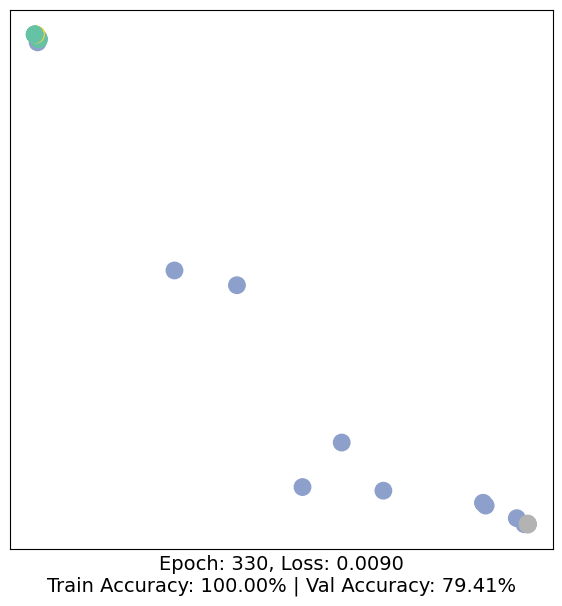

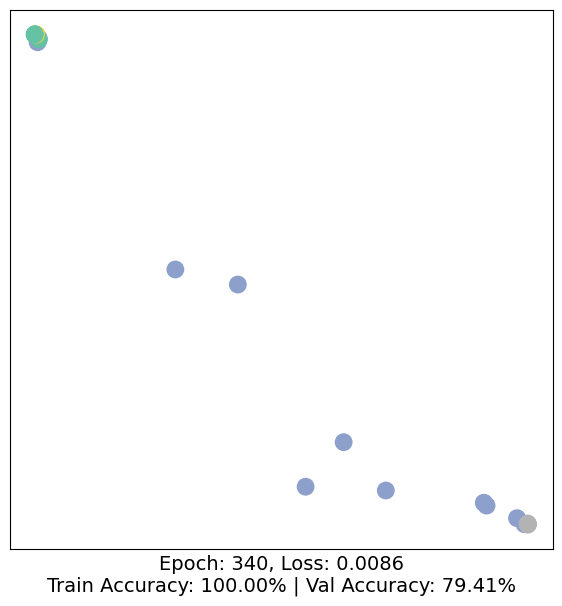

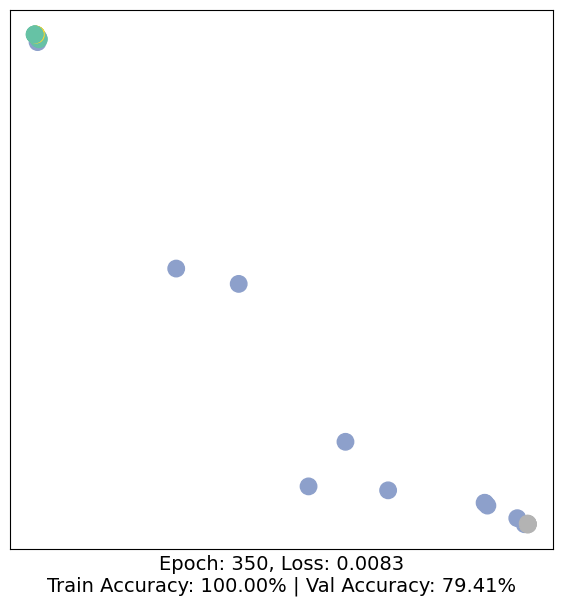

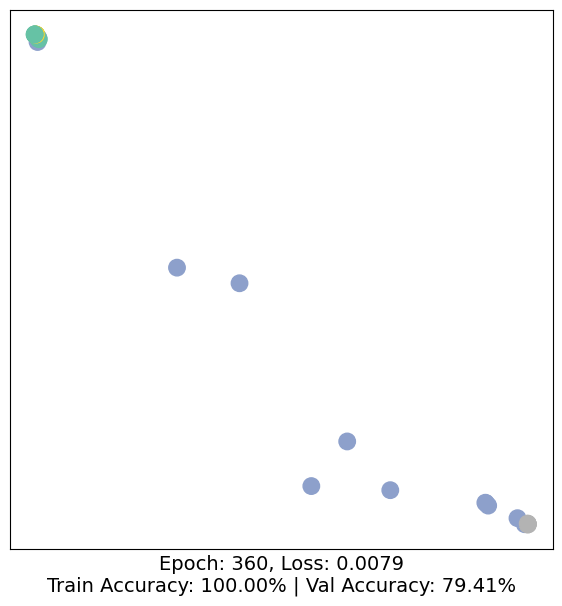

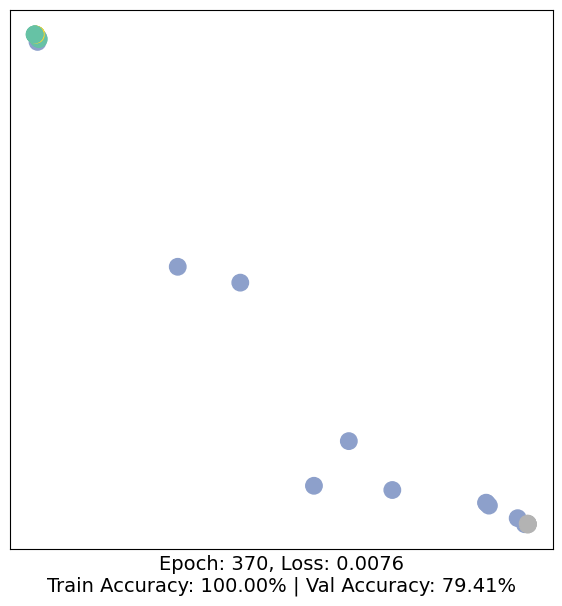

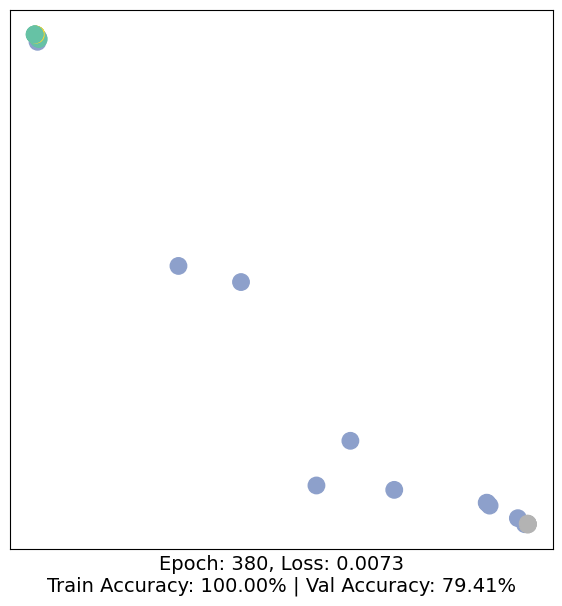

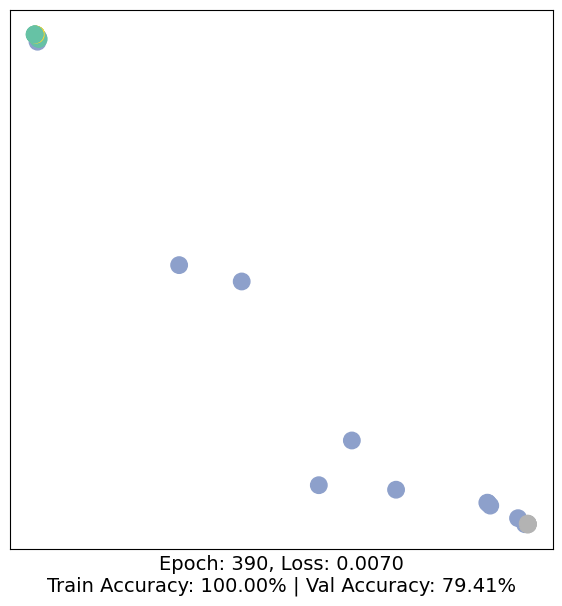

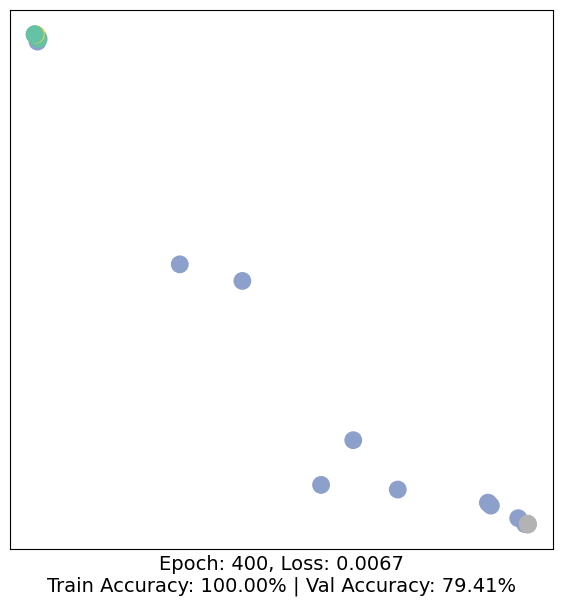

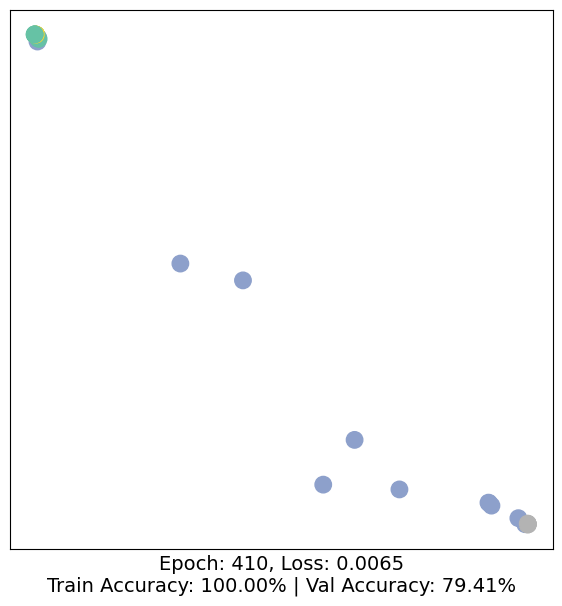

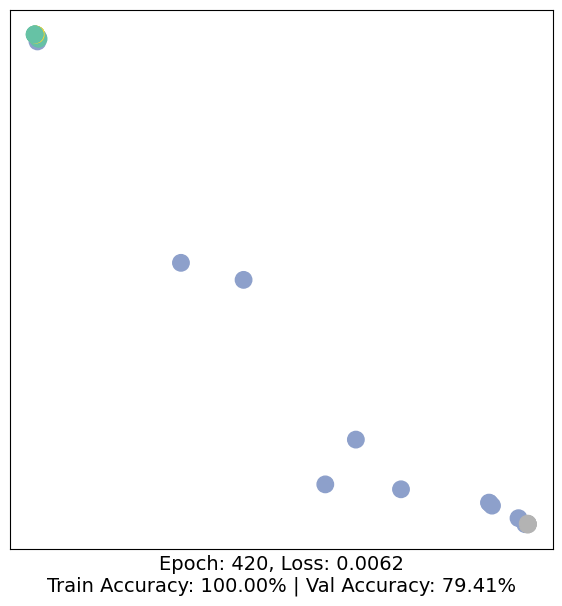

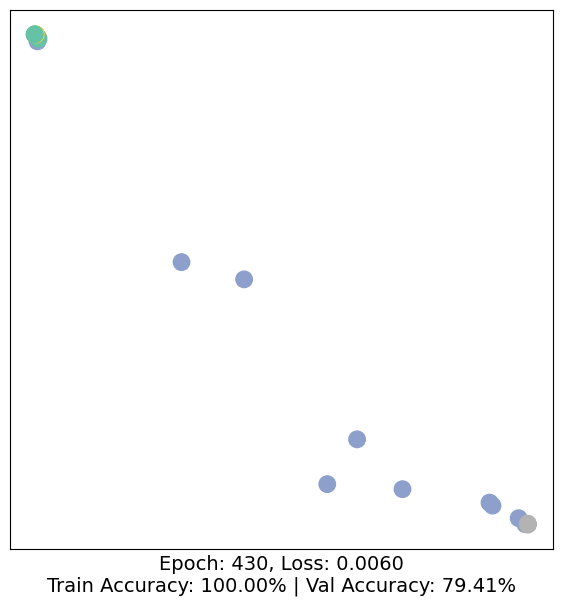

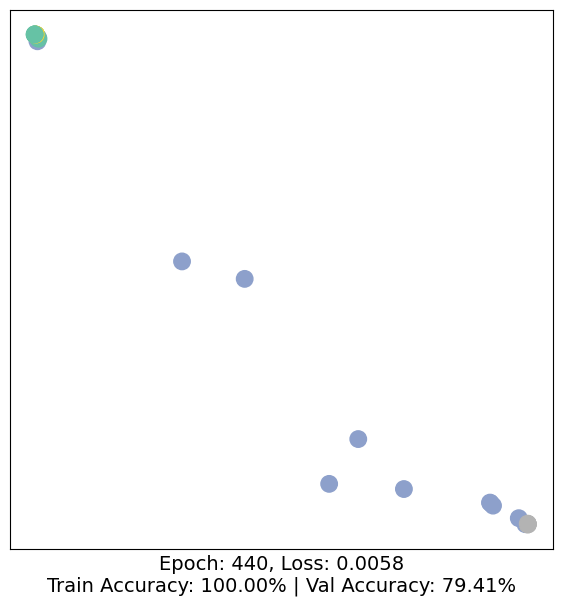

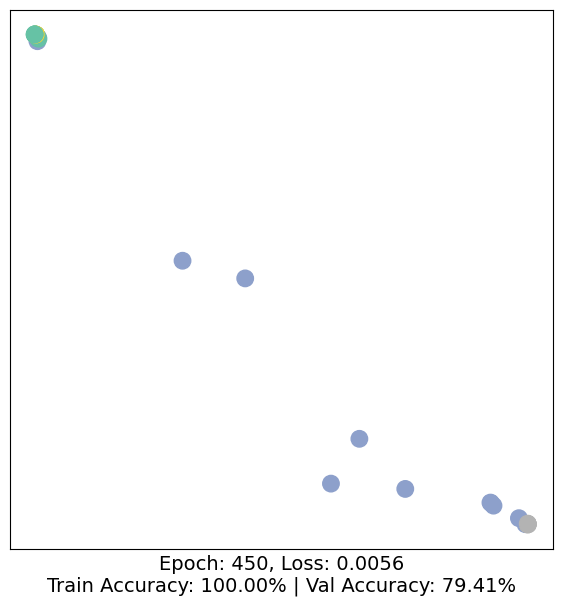

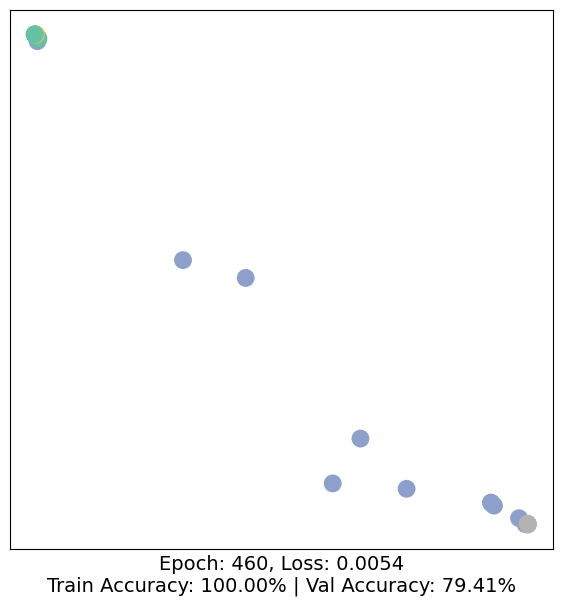

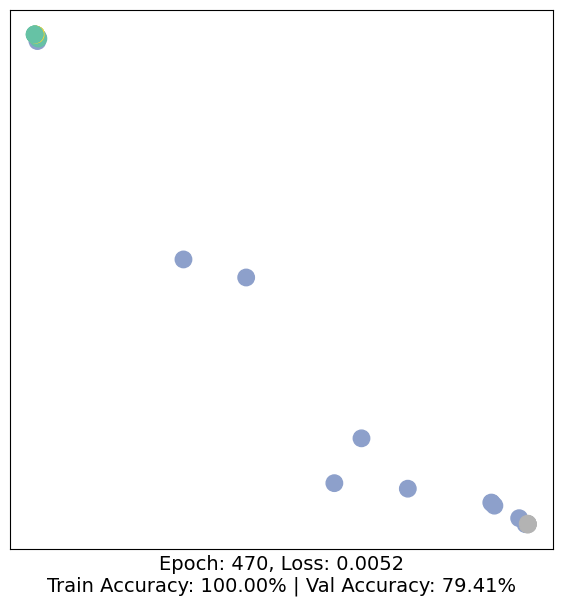

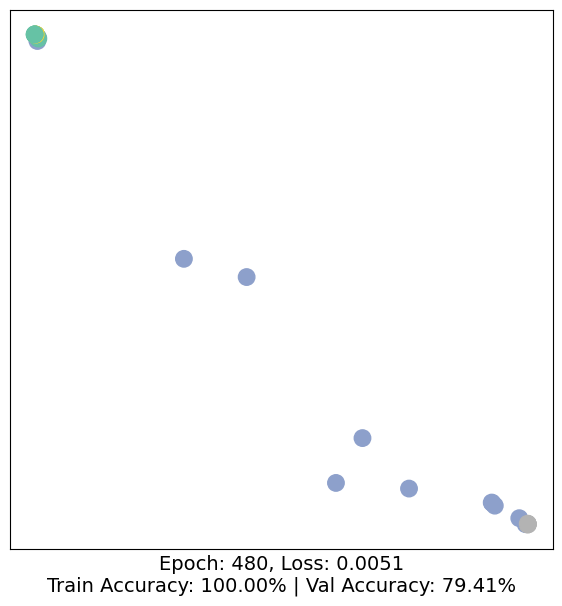

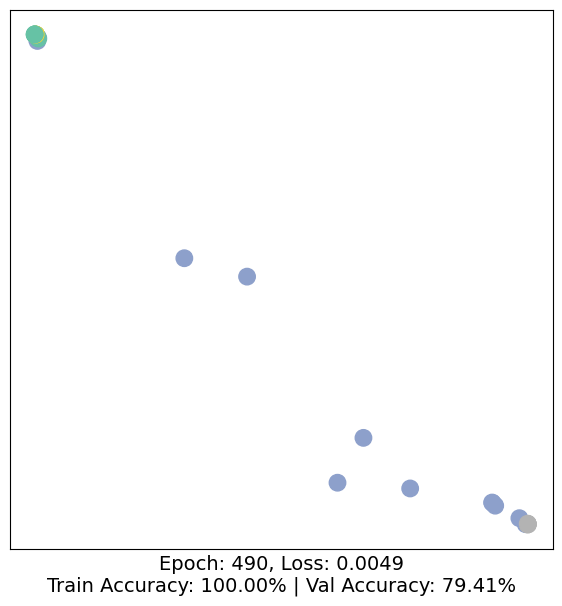

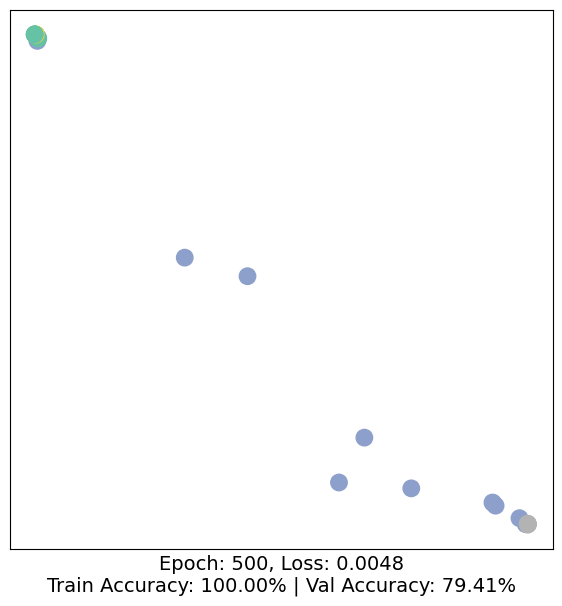


--- End of Karate Club example ---



In [31]:
# --------------------------------------
#  Train the GCN on 4 labeled nodes
# --------------------------------------

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_karate(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)

    # We only compute loss on the training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Compute accuracy for training nodes:
    predicted_train = out[data.train_mask].argmax(dim=1)
    true_train = data.y[data.train_mask]
    train_acc = (predicted_train == true_train).float().mean()

    # Compute accuracy for all nodes (validation sense here)
    predicted_all = out.argmax(dim=1)
    all_acc = (predicted_all == data.y).float().mean()

    return loss, h, {"train": train_acc.item(), "val": all_acc.item()}

import time
for epoch in range(501):
    loss, h, accuracy = train_karate(data)

    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.2)

print("\n--- End of Karate Club example ---\n")


# =======================================================
#      DEMONSTRATION ON OPEN GRAPH BENCHMARK DATA
# =======================================================


## 1. OGBN-Arxiv (Node Property Prediction)

**Data**  
- A large citation network from the **Open Graph Benchmark** (OGB).  
- **Nodes** represent papers posted on arXiv (an e-print service).  
- **Edges** represent citation links between papers.

**Goal**  
- **Node classification** — predict the **subject area** or **category** for each paper (e.g., high-energy physics, machine learning, etc.).  
- The dataset is **transductive**: we can see the entire graph but only have labels for some subset (training nodes), with separate validation and test nodes.

**Key Points**  
- The graph is much **larger** than the Karate Club example.  
- We use a **multi-layer GCN** (with batch normalization, dropout, etc.) to embed each paper and output a predicted class.  
- This highlights how to **load large benchmark datasets (OGB)** and measure performance on **train/val/test splits**.

## 2. OGBG-Molhiv (Graph Property Prediction)

**Data**  
- A **collection of molecule graphs**, each representing a chemical compound.  
- **Nodes** (atoms) have features like atomic number, chirality, etc.  
- **Edges** (bonds) may have properties like bond type (single, double, etc.).

**Goal**  
- **Graph-level classification** — predict whether each molecule is **active** or **inactive** against HIV (a binary label).  
- Rather than classifying individual nodes, here we classify an **entire graph** (each separate molecule).

**Key Points**  
- We first embed the node features (atoms) with a specialized `AtomEncoder`.  
- A GNN (similar structure to our node-level GCN) **learns embeddings** for each node.  
- We then apply **global pooling** (summing or averaging node embeddings) to get a single **“graph-level embedding”**, and apply a final linear layer to produce a **binary classification** (active/inactive).  
- This showcases how **PyTorch Geometric** handles **mini-batches of many small graphs**.


In [35]:
# ----------------------------------
# A) Node Property Prediction with ogbn-arxiv
# ----------------------------------

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

# Load the dataset
dataset_name = 'ogbn-arxiv'
dataset_arxiv = PygNodePropPredDataset(name=dataset_name,
                                       transform=T.ToSparseTensor())
data_arxiv = dataset_arxiv[0]

# Make the adjacency matrix symmetric
# data_arxiv.adj_t = data_arxiv.adj_t.to_symmetric()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_arxiv = data_arxiv.to(device)
split_idx = dataset_arxiv.get_idx_split()
train_idx = split_idx['train'].to(device)

print(f"OGBN-Arxiv dataset loaded.\nDevice: {device}\n")
print(data_arxiv)


OGBN-Arxiv dataset loaded.
Device: cpu

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343])


/Users/mebrahimkhani/miniconda3/envs/gnn/lib/python3.9/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices

In [37]:
# We'll define a multi-layer GCN. This time, let's do a more generic one.

class MultiLayerGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, return_embeds=False):
        super(MultiLayerGCN, self).__init__()

        # For convenience
        self.num_layers = num_layers
        self.dropout = dropout
        self.return_embeds = return_embeds

        # Create lists of GCNConv and batch-norm layers
        from torch.nn import ModuleList, BatchNorm1d, LogSoftmax

        self.convs = ModuleList()
        self.bns = ModuleList()

        # Input -> Hidden
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(BatchNorm1d(hidden_dim))
        # Hidden -> Hidden
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(BatchNorm1d(hidden_dim))
        # Hidden -> Output
        self.convs.append(GCNConv(hidden_dim, output_dim))

        self.softmax = LogSoftmax(dim=1)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # Pass through each GCNConv + BN + ReLU + Dropout
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, adj_t)
            x = F.relu(x)
            x = self.bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Final layer
        x = self.convs[self.num_layers - 1](x, adj_t)

        if not self.return_embeds:
            x = self.softmax(x)  # for classification
        return x

def train_node_classifier(model, data, train_idx, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y[train_idx].view(-1))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate_node_classifier(model, data, split_idx, evaluator, save_results=False):
    model.eval()
    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_results:
        # Save predictions if desired
        pred_file = 'ogbn_arxiv_node_predictions.csv'
        import pandas as pd
        df = pd.DataFrame({'y_pred': y_pred.view(-1).cpu().numpy()})
        df.to_csv(pred_file, index=False)
        print(f"Saved node-level predictions to {pred_file}")

    return train_acc, valid_acc, test_acc

# Hyperparams
num_layers = 3
hidden_dim = 256
dropout = 0.5
lr = 0.01
epochs = 100

# Initialize model and evaluator
model_arxiv = MultiLayerGCN(data_arxiv.num_features, hidden_dim, dataset_arxiv.num_classes,
                            num_layers, dropout).to(device)
evaluator_arxiv = Evaluator(name='ogbn-arxiv')

model_arxiv.reset_parameters()
optimizer = torch.optim.Adam(model_arxiv.parameters(), lr=lr)
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0.0

print("\n--- Training MultiLayerGCN on ogbn-arxiv ---\n")
for epoch in range(1, epochs + 1):
    loss = train_node_classifier(model_arxiv, data_arxiv, train_idx, optimizer, loss_fn)
    train_acc, valid_acc, test_acc = evaluate_node_classifier(model_arxiv, data_arxiv, split_idx, evaluator_arxiv)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = MultiLayerGCN(data_arxiv.num_features, hidden_dim, dataset_arxiv.num_classes,
                                   num_layers, dropout).to(device)
        best_model.load_state_dict(model_arxiv.state_dict())

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Train: {train_acc*100:.2f}% | Valid: {valid_acc*100:.2f}% | Test: {test_acc*100:.2f}%")

# Final evaluation of best model
train_acc, valid_acc, test_acc = evaluate_node_classifier(best_model, data_arxiv, split_idx, evaluator_arxiv, save_results=True)
print("\n=== Final performance of best model ===")
print(f"Train: {train_acc*100:.2f}% | Valid: {valid_acc*100:.2f}% | Test: {test_acc*100:.2f}%")



--- Training MultiLayerGCN on ogbn-arxiv ---

Epoch 010 | Loss: 1.7720 | Train: 39.49% | Valid: 39.16% | Test: 40.39%
Epoch 020 | Loss: 1.6173 | Train: 50.91% | Valid: 50.85% | Test: 49.58%
Epoch 030 | Loss: 1.5460 | Train: 58.21% | Valid: 57.60% | Test: 53.30%
Epoch 040 | Loss: 1.5016 | Train: 59.88% | Valid: 58.39% | Test: 53.50%
Epoch 050 | Loss: 1.4670 | Train: 61.08% | Valid: 58.77% | Test: 52.58%
Epoch 060 | Loss: 1.4392 | Train: 61.64% | Valid: 59.15% | Test: 52.94%
Epoch 070 | Loss: 1.4191 | Train: 62.11% | Valid: 59.02% | Test: 52.57%
Epoch 080 | Loss: 1.3956 | Train: 62.51% | Valid: 59.14% | Test: 52.53%
Epoch 090 | Loss: 1.3820 | Train: 62.88% | Valid: 59.09% | Test: 52.33%
Epoch 100 | Loss: 1.3690 | Train: 63.29% | Valid: 59.49% | Test: 53.37%
Saved node-level predictions to ogbn_arxiv_node_predictions.csv

=== Final performance of best model ===
Train: 63.33% | Valid: 60.04% | Test: 53.84%


In [38]:
# -------------------------------------------------------
# B) Graph Property Prediction with ogbg-molhiv
# -------------------------------------------------------
# We'll do a graph-level classification on molecular data: 
# The ogbg-molhiv dataset. We'll create a GCN that:
#  - Embeds each node
#  - Pools the node embeddings to produce a graph-level embedding
#  - Outputs a graph-level prediction (binary classification)

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
import copy

dataset_mol = PygGraphPropPredDataset(name='ogbg-molhiv')
split_idx_mol = dataset_mol.get_idx_split()
train_loader = DataLoader(dataset_mol[split_idx_mol['train']], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_mol[split_idx_mol['valid']], batch_size=32, shuffle=False)
test_loader  = DataLoader(dataset_mol[split_idx_mol['test']],  batch_size=32, shuffle=False)

print(f"\nLoaded ogbg-molhiv with {len(dataset_mol)} graphs.")
print(f"Task type: {dataset_mol.task_type}\n")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

# We'll use the same MultiLayerGCN but specifically for graph-level tasks.
# We combine an atom encoder, GNN, and global pooling.

class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # For molecular graphs, we first encode node attributes (atoms)
        self.node_encoder = AtomEncoder(hidden_dim)

        # Reuse the MultiLayerGCN but set input_dim=hidden_dim => hidden_dim => output_dim=hidden_dim => we keep "return_embeds=True"
        self.gnn_node = MultiLayerGCN(hidden_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embeds=True)

        # We'll pick a global mean pooling
        self.pool = global_mean_pool

        # Linear final layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def reset_parameters(self):
        self.gnn_node.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, batched_data):
        # batched_data is a mini-batch of graphs from a DataLoader
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch

        # Encode node features
        x = self.node_encoder(x)

        # Produce node embeddings with the GNN
        x = self.gnn_node(x, edge_index)

        # Aggregate (pool) node embeddings into graph embeddings
        x = self.pool(x, batch)

        # Predict graph property
        out = self.linear(x)
        return out

def train_graph_classifier(model, device, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for step, batch_data in enumerate(loader):
        batch_data = batch_data.to(device)

        # Some small graphs or corner cases can skip
        if batch_data.x.shape[0] == 1:
            continue

        optimizer.zero_grad()
        y_pred = model(batch_data)
        # Some graphs may be unlabeled, so we filter them
        is_labeled = batch_data.y == batch_data.y
        # BCEWithLogitsLoss expects float labels
        loss = loss_fn(y_pred[is_labeled], batch_data.y[is_labeled].float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

@torch.no_grad()
def eval_graph_classifier(model, device, loader, evaluator, save_results=False, tag=""):
    model.eval()
    y_true = []
    y_pred = []
    for batch_data in loader:
        batch_data = batch_data.to(device)
        if batch_data.x.shape[0] == 1:
            continue
        pred = model(batch_data)
        y_true.append(batch_data.y.view(pred.shape).cpu())
        y_pred.append(pred.cpu())

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}
    result = evaluator.eval(input_dict)

    if save_results:
        import pandas as pd
        df = pd.DataFrame({"y_pred": y_pred.reshape(-1), "y_true": y_true.reshape(-1)})
        csv_name = f"ogbg_molhiv_{tag}.csv"
        df.to_csv(csv_name, index=False)
        print(f"Saved predictions to {csv_name}")

    return result

# We'll do ~30 epochs of training
num_layers = 5
hidden_dim = 256
output_dim = dataset_mol.num_tasks  # For ogbg-molhiv, this is 1
dropout = 0.5
lr = 0.001
epochs = 30

model_mol = GCN_Graph(hidden_dim, output_dim, num_layers, dropout).to(device)
evaluator_mol = Evaluator(name="ogbg-molhiv")
model_mol.reset_parameters()

optimizer = torch.optim.Adam(model_mol.parameters(), lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary classification (with logits)

best_model = None
best_valid_rocauc = 0.0

print("\n--- Training GCN for Graph Classification on ogbg-molhiv ---\n")
for epoch in range(1, epochs + 1):
    loss = train_graph_classifier(model_mol, device, train_loader, optimizer, loss_fn)

    train_res = eval_graph_classifier(model_mol, device, train_loader, evaluator_mol)
    valid_res = eval_graph_classifier(model_mol, device, valid_loader, evaluator_mol)
    test_res  = eval_graph_classifier(model_mol, device, test_loader,  evaluator_mol)

    train_rocauc = train_res[dataset_mol.eval_metric]
    valid_rocauc = valid_res[dataset_mol.eval_metric]
    test_rocauc  = test_res[dataset_mol.eval_metric]

    if valid_rocauc > best_valid_rocauc:
        best_valid_rocauc = valid_rocauc
        best_model = copy.deepcopy(model_mol)

    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | "
              f"Train: {train_rocauc*100:.2f}% | Valid: {valid_rocauc*100:.2f}% | Test: {test_rocauc*100:.2f}%")

best_train = eval_graph_classifier(best_model, device, train_loader, evaluator_mol)
best_valid = eval_graph_classifier(best_model, device, valid_loader, evaluator_mol, save_results=True, tag="valid")
best_test  = eval_graph_classifier(best_model, device, test_loader,  evaluator_mol, save_results=True,  tag="test")

train_roc = best_train[dataset_mol.eval_metric] * 100
val_roc   = best_valid[dataset_mol.eval_metric] * 100
test_roc  = best_test[dataset_mol.eval_metric]  * 100

print("\n=== Best model performance on ogbg-molhiv ===")
print(f"Train: {train_roc:.2f}% | Valid: {val_roc:.2f}% | Test: {test_roc:.2f}%\n")

print("Tutorial Finished.\n")
print("You have explored:")
print("- NetworkX for basic graph operations")
print("- PyTorch Geometric for GNN-based node/graph classification")
print("- Common GNN layers (GCNConv)")
print("- Semi-supervised node classification on Karate Club & ogbn-arxiv")
print("- Graph-level classification on ogbg-molhiv")

# End of Notebook


Downloaded 0.00 GB: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 311146.76it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:00<00:00, 82587.32it/s]


Saving...


Done!
/Users/mebrahimkhani/miniconda3/envs/gnn/lib/python3.9/site-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self


Loaded ogbg-molhiv with 41127 graphs.
Task type: binary classification


--- Training GCN for Graph Classification on ogbg-molhiv ---

Epoch 05 | Loss: 148.4275 | Train: 75.22% | Valid: 71.65% | Test: 69.78%
Epoch 10 | Loss: 143.8664 | Train: 76.68% | Valid: 72.14% | Test: 72.73%
Epoch 15 | Loss: 137.9326 | Train: 79.71% | Valid: 77.94% | Test: 72.35%
Epoch 20 | Loss: 134.4963 | Train: 80.32% | Valid: 79.45% | Test: 71.65%
Epoch 25 | Loss: 130.8448 | Train: 81.02% | Valid: 74.47% | Test: 70.88%
Epoch 30 | Loss: 128.9185 | Train: 83.20% | Valid: 78.52% | Test: 74.37%
Saved predictions to ogbg_molhiv_valid.csv
Saved predictions to ogbg_molhiv_test.csv

=== Best model performance on ogbg-molhiv ===
Train: 80.69% | Valid: 80.32% | Test: 72.99%

Tutorial Finished.

You have explored:
- NetworkX for basic graph operations
- PyTorch Geometric for GNN-based node/graph classification
- Common GNN layers (GCNConv)
- Semi-supervised node classification on Karate Club & ogbn-arxiv
- Graph-level c